# Creating an optimal Molecule's Potential Energy Curve using Adapt-VQE

The main idea is to create an iterator that manipulates the C-NOT quantity and circuit depth to implement a VQE on a more efficient way. We are using as an example of implementation the energy curve for a molecule pair.  

## Libraries

In [18]:
import time
import matplotlib.pyplot as plt
import numpy as np
import itertools

from classiq import * 
from classiq.applications.chemistry import *
from classiq.execution import *
from classiq.interface.backend.backend_preferences import IBMBackendPreferences, ClassiqSimulatorBackendNames
#from classiq.interface.executor.hamiltonian_minimization_problem import *
from classiq.interface.executor.quantum_instruction_set import QuantumInstructionSet
#from classiq.interface.executor import QuantumProgram
from classiq.applications.combinatorial_helpers.pauli_helpers.pauli_utils import pauli_operator_to_hamiltonian
from classiq.qmod.symbolic import ceiling as ceiling_qmod, pi

## Anti-Bug: Molecule Validation

In [19]:
def validate_molecule(mol):
    if not isinstance(mol, Molecule):
        raise TypeError("The object 'mol' must be Molecule type")
    if not mol.atoms or len(mol.atoms) < 2:
        raise ValueError("The molecule must have at least 2 atoms.")


## 0. Distances and Define Molecules
We start this defining some examples of molecular pairs and triplets.

In [20]:
# Define 2 distance intervals and create the distance vector
num1, start1, stop1 = 7, 0.20, 1   #First Linear Space 
num2, start2, stop2 = 6, 1.4, 3  #Second Linear Space
distance = np.append(np.linspace(start1, stop1, num1), np.linspace(start2, stop2, num2)) # prepare x,y vectors

#Create a list of molecules for each distance
molecules_LiH = [Molecule(atoms=[("H", (0.0, 0.0, 0.0)), ("Li", (0.0, 0.0, x))]) for x in distance]
molecules_FH = [Molecule(atoms=[("H", (0.0, 0.0, 0.0)), ("F", (0.0, 0.0, x))]) for x in distance]
molecules_H2 = [Molecule(atoms=[("H", (0.0, 0.0, 0)), ("H", (0.0, 0.0, x))]) for x in distance]
molecules_O2 = [Molecule(atoms=[("O", (0.0, 0.0, 0)), ("O", (0.0, 0.0, x))]) for x in distance]
molecules_H2O = [Molecule(atoms=[("O", (0.0, 0.0, 0.0)), ("H", (0, x, y)), ("H", (0, x, -y))]) for (x,y) in itertools.product(distance,distance)]
molecules_H3 = [Molecule(atoms=[("H", (0.0, 0.0, 0.0)), ("H", (0, x, y)), ("H", (0, x, -y))]) for (x,y)  in itertools.product(distance,distance)]
molecules_O3 = [Molecule(atoms=[("O", (0.0, 0.0, 0.0)), ("O", (0, x, y)), ("O", (0, x, -y))]) for (x,y)  in itertools.product(distance,distance)]
molecules_BeH2 = [Molecule(atoms=[("Be", (0.0, 0.0, 0.0)), ("H", (0, 0, x)), ("H", (0, 0, -x))]) for x in distance]

## 1. Vanilla VQE
This part would imitate the model of VQE already implemented on Classiq

In [21]:
# Lists to store energies and durations
fixed_vqe_energy = []
adapt_vqe_energy = []
hf_energy = []
exact_energy = []
durations_fixed = []
durations_adapt = []

# Lists to store objects for reference
qmods = []
qprogs = []
results = []

In [22]:
# Functions that will be used

# Create and return MoleculeProblem, a basis can be specified or otherwise the predetermined one is used
def create_problem(molecule, mapping="jordan_wigner", basis=None):
    if basis is None:
        return MoleculeProblem(molecule=molecule, mapping=mapping, z2_symmetries=True, freeze_core=True)
    else:
        return MoleculeProblem(molecule=molecule, basis=basis, mapping=mapping, z2_symmetries=True, freeze_core=True)

# Cut terms with coefficients lower than the threshold and normalize the hamiltonian
def process_hamiltonian(operator, threshold=0.03):
    ham_list = pauli_operator_to_hamiltonian(operator.pauli_list)
    if not ham_list:
        warnings.warn("The list of terms in the Hamiltonian is empty.")
        return 1.0, []
    trimmed = [term for term in ham_list if np.abs(term.coefficient) > threshold]
    if not trimmed:
        warnings.warn("No term exceeds the threshold, so the original Hamiltonian will be used.")
        trimmed = ham_list
    norm_factor = 2 * sum(np.abs(term.coefficient) for term in trimmed)
    if norm_factor == 0:
        raise ValueError("The normalization factor is 0. Please check the coefficients.")
    normalized = [PauliTerm(pauli=term.pauli, coefficient=term.coefficient / norm_factor)
                  for term in trimmed]
    return norm_factor, normalized

# Define the Fixed VQE (Vanilla VQE) and return the dictionary of results
def run_fixed_vqe(molecule, max_iter=10):
    chem_problem = create_problem(molecule, mapping="jordan_wigner")
    qmod = construct_chemistry_model(
        chemistry_problem=chem_problem,
        use_hartree_fock=True,
        ansatz_parameters=UCCParameters(excitations=[1, 2]),
        execution_parameters=ChemistryExecutionParameters(
            optimizer=OptimizerType.COBYLA,
            max_iteration=max_iter,
            initial_point=None
        )
    )
    qprog = synthesize(qmod)
    result = execute(qprog).result()
    return result[1].value, chem_problem

In [ ]:
# Run the Fixed VQE (Vanilla VQE)
for k in range(len(distance)):
    molecule = molecules_H2[k]
    t1 = time.time()
    chem_result, problem_fixed = run_fixed_vqe(molecule)
    durations_fixed.append(time.time() - t1)
    fixed_vqe_energy.append(chem_result["total_energy"])
    hf_energy.append(chem_result["hartree_fock_energy"])
    
    # Exact solution from the generated hamiltonian
    operator_fixed = problem_fixed.generate_hamiltonian()
    mat_fixed = operator_fixed.to_matrix()
    w_fixed, _ = np.linalg.eig(mat_fixed)
    exact_val = np.real(min(w_fixed)) + chem_result["nuclear_repulsion_energy"]
    exact_energy.append(exact_val)
    
    # Store objects for reference
    qmods.append(problem_fixed)
    results.append(chem_result)

# 2. Define AdaptVQE 
In this part of the notebook, we implement the aVQE function, that depends of the array of points we want to calculate, the molecule pair we are modelling, and a threshold number. While the distance between the VQE and the exact solution arrays is bigger than the threshold, it will be relaxed the limit used. This process will be done until the distance is lesser than the threshold. 

In [ ]:
# Define Adapt-VQE using fixed UCCParameters but with constraints like depth adaptation and number of CNOTS.
# Return a dictionary of results
def run_adapt_vqe(molecule, max_iter=10, m_depth=10, m_cnot=10):
    chem_problem = create_problem(molecule, mapping="bravyi_kitaev", basis="sto3g")
    qmod = construct_chemistry_model(
        chemistry_problem=chem_problem,
        use_hartree_fock=True,
        ansatz_parameters=UCCParameters(excitations=[1, 2]),
        execution_parameters=ChemistryExecutionParameters(
            optimizer=OptimizerType.COBYLA,
            max_iteration=max_iter,
            initial_point=None
        )
    )
    preferences = Preferences(optimization_level=3)
    constraints = Constraints(max_depth=m_depth, max_gate_count={TranspilerBasisGates.CX: m_cnot})
    qprog = synthesize(qmod, constraints=constraints, preferences=preferences)
    result = execute(qprog).result()
    return result[1].value, chem_problem

In [ ]:
# Run Adapt-VQE with adapted constraints
for k in range(len(distance)):
    mol = molecules_H2[k]
    t2 = time.time()
    chem_result_adapt, problem_adapt = run_adapt_vqe(mol, max_iter=10, m_depth=10, m_cnot=10)
    durations_adapt.append(time.time() - t2)
    adapt_vqe_energy.append(chem_result_adapt["total_energy"])
    
    #Optionally: Process the hamiltonian to use the truncated version of the hamiltonian
    # operator_adapt = problem_adapt.generate_hamiltonian()
    # norm, norm_ham = process_hamiltonian(operator_adapt, threshold=0.03)
    
    qmods.append(problem_adapt)
    results.append(chem_result_adapt)

## 3. Plot and comparing results

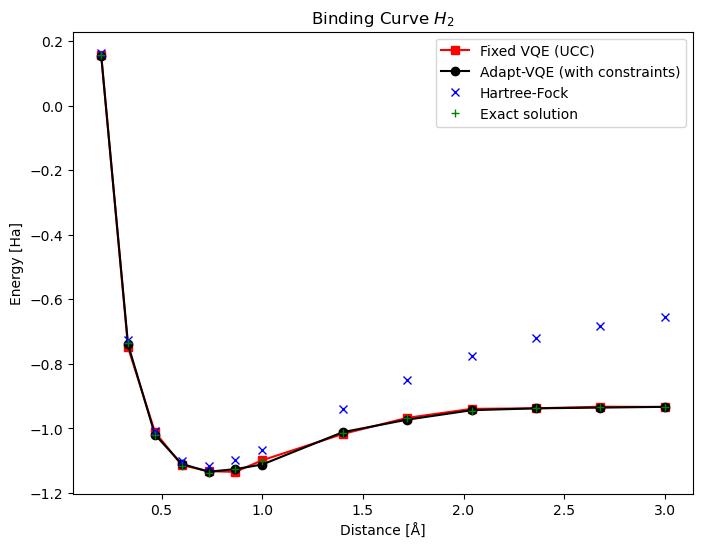

Minimum Energy Fixed VQE: -1.1348956656983207
Minimum Energy Adapt-VQE: -1.1345281271269982
Minimum Energy Hartree-Fock: -1.117069053137786
Exact Minumum Energy: -1.1373040455964771
Fixed VQE average time: 12.015480004824125
Adapt-VQE average time: 11.566018067873442


ValidationError: 1 validation error for Model
  JSON input should be string, bytes or bytearray [type=json_type, input_value=[], input_type=list]
    For further information visit https://errors.pydantic.dev/2.9/v/json_type

In [ ]:

# Plot and compare results
plt.figure(figsize=(8,6))
plt.plot(distance, fixed_vqe_energy, "r-s", label="Fixed VQE (UCC)")
plt.plot(distance, adapt_vqe_energy, "k-o", label="Adapt-VQE (with constraints)")
plt.plot(distance, hf_energy, "bx", label="Hartree-Fock")
plt.plot(distance, exact_energy, "g+", label="Exact solution")
plt.xlabel(r"Distance [Å]")
plt.ylabel("Energy [Ha]")
plt.legend()
plt.title(r"Binding Curve $H_{2}$")
plt.show()

print("Minimum Energy Fixed VQE:", min(fixed_vqe_energy))
print("Minimum Energy Adapt-VQE:", min(adapt_vqe_energy))
print("Minimum Energy Hartree-Fock:", min(hf_energy))
print("Exact Minumum Energy:", min(exact_energy))
print("Fixed VQE average time:", np.mean(durations_fixed))
print("Adapt-VQE average time:", np.mean(durations_adapt))

write_qmod(qprogs, 'x')

